In [1]:
using AlgebraicStockFlow

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

# Open Population SIR model Construction

In [3]:
# define constant parameters
p = LVector(
    cbeta=0.1, rbirth=0.001, rdeath=0.001, rrecovery=0.05, # for model sir
    rvaccine=0.01, evaccine=0.3 # for model svi
)

6-element LArray{Float64, 1, Vector{Float64}, (:cbeta, :rbirth, :rdeath, :rrecovery, :rvaccine, :evaccine)}:
     :cbeta => 0.1
    :rbirth => 0.001
    :rdeath => 0.001
 :rrecovery => 0.05
  :rvaccine => 0.01
  :evaccine => 0.3

In [4]:
# define the function of the dynamical variables
f_birth(u,uN,t)=p.rbirth*uN.N(u,t)
f_inf(u,uN,t)= p.cbeta*u.S*u.I/uN.N(u,t)
f_rec(u,uN,t)=p.rrecovery*u.I
f_deathS(u,uN,t)=u.S*p.rdeath
f_deathI(u,uN,t)=u.I*p.rdeath
f_deathR(u,uN,t)=u.R*p.rdeath

f_deathR (generic function with 1 method)

In [5]:
#(stock_name, initialvalue)=>(inflows, outflows, variables, svariables)
#(flow=>variable)
#(variable=>function)
#(svariable=>variable)
sir=StockAndFlow(
    ((:S, 990)=>(:birth,(:inf,:deathS),(:v_inf,:v_deathS),:N), (:I, 10)=>(:inf,(:rec,:deathI),(:v_inf, :v_rec,:v_deathI),:N),(:R, 0)=>(:rec,:deathR,:v_deathR,:N)),
    (:birth=>:v_birth,:inf=>:v_inf,:rec=>:v_rec,:deathS=>:v_deathS,:deathI=>:v_deathI,:deathR=>:v_deathR),
    (:v_birth=>f_birth,:v_inf=>f_inf,:v_rec=>f_rec,:v_deathS=>f_deathS,:v_deathI=>f_deathI,:v_deathR=>f_deathR),
    (:N=>(:v_birth,:v_inf))
)

StockAndFlow with elements S = 1:3, SV = 1:1, LS = 1:3, F = 1:6, I = 1:3, O = 1:5, V = 1:6, LV = 1:6, LSV = 1:2
┌───┬──────────────┬───────┐
│ S │ initialValue │ sname │
├───┼──────────────┼───────┤
│ 1 │          990 │     S │
│ 2 │           10 │     I │
│ 3 │            0 │     R │
└───┴──────────────┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
└────┴─────┴──────┘
┌───┬────┬────────┐
│ F │ fv │  fname │
├───┼────┼────────┤
│ 1 │  1 │  birth │
│ 2 │  2 │    inf │
│ 3 │  3 │    rec │
│ 4 │  4 │ deathS │
│ 5 │  5 │ deathI │
│ 6 │  6 │ deathR │
└───┴────┴────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  2 │
│ 3 │   3 │  3 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   4 │  1 │
│ 3 │   3 │  2 │
│ 4 │   5 │  2 │
│ 5 │   6 │  3 │
└───┴─────┴────┘
┌───┬───────────┬──────────┐
│ V │ funcDynam │    vname │
├───┼───────────┼──────────┤
│ 1 │   f_birth │  v_birth │
│ 2 │     f_inf │    v_inf │
│ 3 │     f_rec │    v_rec │
│ 4 │  f_deathS │ v_deathS │
│ 5 │  f_deathI │ v_deathI │
│ 6 │  f_deathR │ v_deathR │
└───┴───────────┴──────────┘
┌────┬─────┬─────┐
│ LV │ lvs │ lvv │
├────┼─────┼─────┤
│  1 │   1 │   2 │
│  2 │   1 │   4 │
│  3 │   2 │   2 │
│  4 │   2 │   3 │
│  5 │   2 │   5 │
│  6 │   3 │   6 │
└────┴─────┴─────┘
┌─────┬───────┬──────┐
│ LSV │ lsvsv │ lsvv │
├─────┼───────┼──────┤
│   1 │     1 │    1 │
│   2 │     1 │    2 │
└─────┴───────┴──────┘

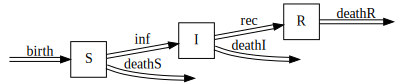

In [6]:
# only plot stocks and flows
Graph(sir; type="SF")

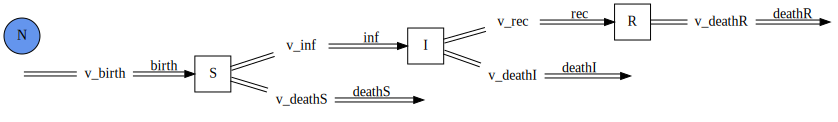

In [7]:
# plot stocks, flows, sum-dynamical variables, and dynamical variables (only not plot links)
Graph(sir; type="SFV")

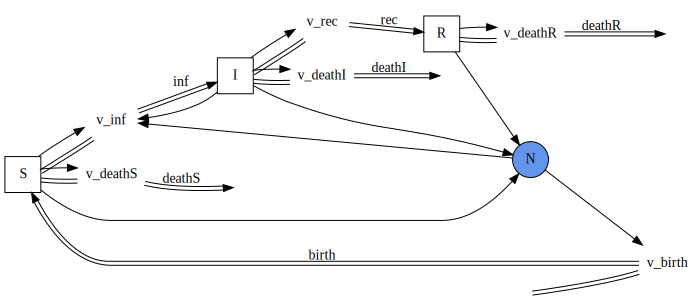

In [8]:
# plot all components of stock and flow diagrams
Graph(sir)

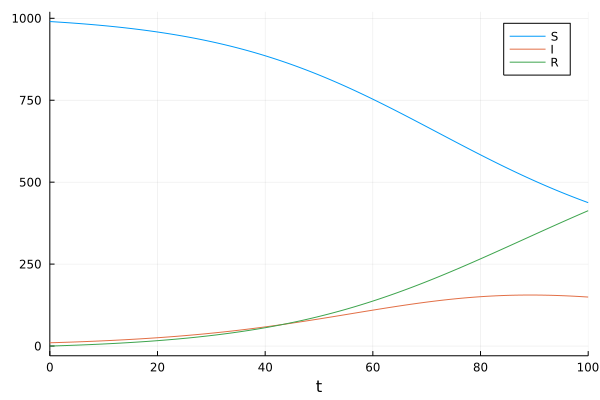

In [9]:
prob_sir = ODEProblem(vectorfield(sir),initialValues(sir),(0.0,100.0),funcFlows(sir));
sol_sir = solve(prob_sir,Tsit5(),abstol=1e-8);
plot(sol_sir)

# Open Population SVI model Construction

In [10]:
f_vacc(u,uN,t)=u.S*p.rvaccine
f_deathV(u,uN,t)=u.V*p.rdeath
f_infv(u,uN,t)=p.cbeta*(1.0-p.evaccine)*u.V*u.I/uN.N(u,t)

f_infv (generic function with 1 method)

In [11]:
#(stock_name, initialvalue)=>(inflows, outflows, variables, svariables)
#(flow=>variable)
#(variable=>function)
#(svariable=>variable)
svi=StockAndFlow(
    ((:S, 990)=>(:F_NONE,:vacc,:v_vacc,:N), (:V, 0)=>(:vacc,(:deathV,:infv),(:v_deathV, :v_infv),:N), (:I, 10)=>(:infv,:F_NONE,:V_NONE,:N)),
    (:vacc=>:v_vacc,:deathV=>:v_deathV, :infv=>:v_infv),
    (:v_vacc=>f_vacc,:v_deathV=>f_deathV,:v_infv=>f_infv),
    (:N=>:v_infv)
)

StockAndFlow with elements S = 1:3, SV = 1:1, LS = 1:3, F = 1:3, I = 1:2, O = 1:3, V = 1:3, LV = 1:3, LSV = 1:1
┌───┬──────────────┬───────┐
│ S │ initialValue │ sname │
├───┼──────────────┼───────┤
│ 1 │          990 │     S │
│ 2 │            0 │     V │
│ 3 │           10 │     I │
└───┴──────────────┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
└────┴─────┴──────┘
┌───┬────┬────────┐
│ F │ fv │  fname │
├───┼────┼────────┤
│ 1 │  1 │   vacc │
│ 2 │  2 │ deathV │
│ 3 │  3 │   infv │
└───┴────┴────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  2 │
│ 2 │   3 │  3 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  2 │
│ 3 │   3 │  2 │
└───┴─────┴────┘
┌───┬───────────┬──────────┐
│ V │ funcDynam │    vname │
├───┼───────────┼──────────┤
│ 1 │    f_vacc │   v_vacc │
│ 2 │  f_deathV │ v_deathV │
│ 3 │    f_infv │   v_infv │
└───┴───────────┴──────────┘
┌────┬─────┬─────┐
│ LV │ lvs │ lvv │
├────┼─────┼─────┤
│  1 │   1 │   1 │
│  2 │   2 │   2 │
│  3 │   2 │   3 │
└────┴─────┴─────┘
┌─────┬───────┬──────┐
│ LSV │ lsvsv │ lsvv │
├─────┼───────┼──────┤
│   1 │     1 │    3 │
└─────┴───────┴──────┘

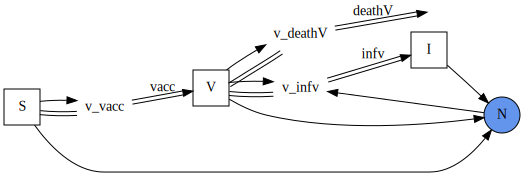

In [12]:
Graph(svi)

# Open the Stock and Flow Diagrams

In [18]:
# composed part definition: 
# 1. (stocks, stock=>svariables) or
# 2. stocks
open_sir = Open(sir, foot(sir, :R),foot(sir, (:S, :I), (:S=>:N,:I=>:N)))

StructuredCospan{Catlab.CategoricalAlgebra.StructuredCospans.SubStructACSet{StockAndFlow0, StockAndFlow}, Multicospan{StockAndFlow, TightACSetTransformation{Catlab.Theories.SchemaDescType{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV), (:lss, :lssv, :ifn, :is, :ofn, :os, :fv, :lvs, :lvv, :lsvsv, :lsvv), (:Name, :InitialValue, :FuncDynam), (:initialValue, :sname, :svname, :funcDynam, :fname, :vname), (lss = 3, lssv = 3, ifn = 5, is = 5, ofn = 6, os = 6, fv = 4, lvs = 8, lvv = 8, lsvsv = 9, lsvv = 9, initialValue = 1, sname = 1, svname = 2, funcDynam = 7, fname = 4, vname = 7), (lss = 1, lssv = 2, ifn = 4, is = 1, ofn = 4, os = 1, fv = 7, lvs = 1, lvv = 7, lsvsv = 2, lsvv = 7, initialValue = 2, sname = 1, svname = 1, funcDynam = 3, fname = 1, vname = 1)}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int

In [14]:
open_svi = Open(svi, foot(svi, (:S, :I), (:S=>:N,:I=>:N)), foot(svi, :V))

StructuredCospan{Catlab.CategoricalAlgebra.StructuredCospans.SubStructACSet{StockAndFlow0, StockAndFlow}, Multicospan{StockAndFlow, TightACSetTransformation{Catlab.Theories.SchemaDescType{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV), (:lss, :lssv, :ifn, :is, :ofn, :os, :fv, :lvs, :lvv, :lsvsv, :lsvv), (:Name, :InitialValue, :FuncDynam), (:initialValue, :sname, :svname, :funcDynam, :fname, :vname), (lss = 3, lssv = 3, ifn = 5, is = 5, ofn = 6, os = 6, fv = 4, lvs = 8, lvv = 8, lsvsv = 9, lsvv = 9, initialValue = 1, sname = 1, svname = 2, funcDynam = 7, fname = 4, vname = 7), (lss = 1, lssv = 2, ifn = 4, is = 1, ofn = 4, os = 1, fv = 7, lvs = 1, lvv = 7, lsvsv = 2, lsvv = 7, initialValue = 2, sname = 1, svname = 1, funcDynam = 3, fname = 1, vname = 1)}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV), Tuple{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}, Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int

# Compostion

In [15]:
open_sirv = compose(open_sir,open_svi)

StructuredCospan{Catlab.CategoricalAlgebra.StructuredCospans.SubStructACSet{StockAndFlow0, StockAndFlow}, Multicospan{StockAndFlow, TightACSetTransformation{Catlab.Theories.SchemaDescType{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV), (:lss, :lssv, :ifn, :is, :ofn, :os, :fv, :lvs, :lvv, :lsvsv, :lsvv), (:Name, :InitialValue, :FuncDynam), (:initialValue, :sname, :svname, :funcDynam, :fname, :vname), (lss = 3, lssv = 3, ifn = 5, is = 5, ofn = 6, os = 6, fv = 4, lvs = 8, lvv = 8, lsvsv = 9, lsvv = 9, initialValue = 1, sname = 1, svname = 2, funcDynam = 7, fname = 4, vname = 7), (lss = 1, lssv = 2, ifn = 4, is = 1, ofn = 4, os = 1, fv = 7, lvs = 1, lvv = 7, lsvsv = 2, lsvv = 7, initialValue = 2, sname = 1, svname = 1, funcDynam = 3, fname = 1, vname = 1)}, NamedTuple{(:S, :SV, :LS, :F, :I, :O, :V, :LV, :LSV), NTuple{9, Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}}}, StockAndFlow, StockAndFlow}, StaticArrays.SVector{2,

In [16]:
sirv = apex(open_sirv)

StockAndFlow with elements S = 1:4, SV = 1:1, LS = 1:4, F = 1:9, I = 1:5, O = 1:8, V = 1:9, LV = 1:9, LSV = 1:3
┌───┬──────────────┬───────┐
│ S │ initialValue │ sname │
├───┼──────────────┼───────┤
│ 1 │          990 │     S │
│ 2 │           10 │     I │
│ 3 │            0 │     R │
│ 4 │            0 │     V │
└───┴──────────────┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
│  4 │   4 │    1 │
└────┴─────┴──────┘
┌───┬────┬────────┐
│ F │ fv │  fname │
├───┼────┼────────┤
│ 1 │  1 │  birth │
│ 2 │  2 │    inf │
│ 3 │  3 │    rec │
│ 4 │  4 │ deathS │
│ 5 │  5 │ deathI │
│ 6 │  6 │ deathR │
│ 7 │  7 │   vacc │
│ 8 │  8 │ deathV │
│ 9 │  9 │   infv │
└───┴────┴────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  2 │
│ 3 │   3 │  3 │
│ 4 │   7 │  4 │
│ 5 │   9 │  2 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   2 │  1 │
│ 2 │   4 │  1 │
│ 3 │   3 │  2 │
│ 4 │   5 │  2 │
│ 5 │   6 │  3 │
│ 6 │   7 │  1 │
│ 7 │   8 │  4 │
│ 8 │   9 │  4 │
└───┴─────┴────┘
┌───┬───────────┬──────────┐
│ V │ funcDynam │    vname │
├───┼───────────┼──────────┤
│ 1 │   f_birth │  v_birth │
│ 2 │     f_inf │    v_inf │
│ 3 │     f_rec │    v_rec │
│ 4 │  f_deathS │ v_deathS │
│ 5 │  f_deathI │ v_deathI │
│ 6 │  f_deathR │ v_deathR │
│ 7 │    f_vacc │   v_vacc │
│ 8 │  f_deathV │ v_deathV │
│ 9 │    f_infv │   v_infv │
└───┴───────────┴──────────┘
┌────┬─────┬─────┐
│ LV │ lvs │ lvv │
├────┼─────┼─────┤
│  1 │   1 │   2 │
│  2 │   1 │   4 │
│  3 │   2 │   2 │
│  4 │   2 │   3 │
│  5 │   2 │   5 │
│  6 │   3 │   6 │
│  7 │   1 │   7 │
│  8 │   4 │   8 │
│  9 │   4 │   9 │
└────┴─────┴─────┘
┌─────┬───────┬──────┐
│ LSV │ lsvsv │ lsvv │
├─────┼───────┼──────┤
│   1 │     1 │    1 │
│   2 │     1 │    2 │
│   3 │     1 │    9 │
└─────┴───────┴──────┘

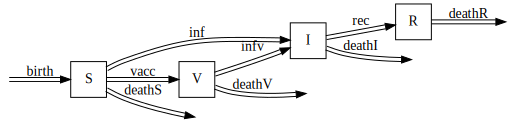

In [17]:
Graph(sirv; type="SF")

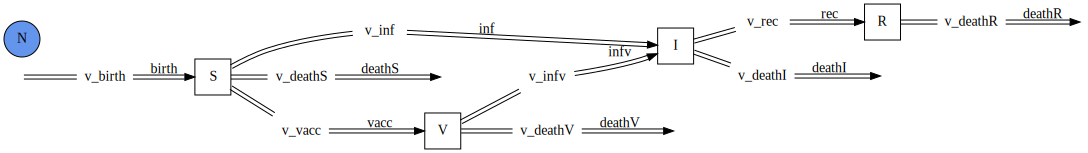

In [19]:
Graph(sirv; type="SFV")

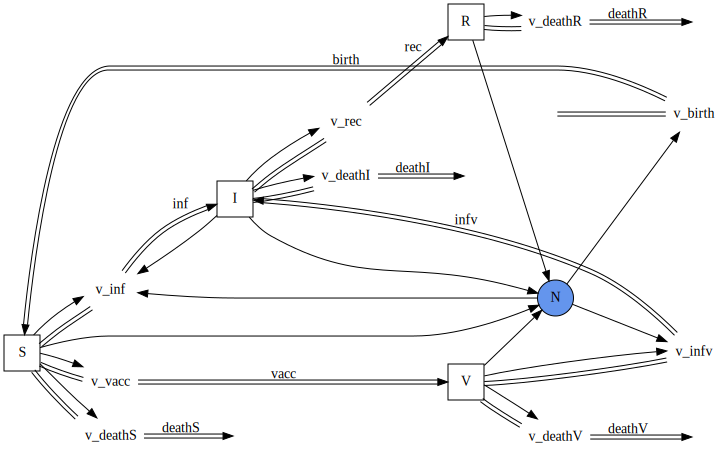

In [20]:
Graph(sirv)

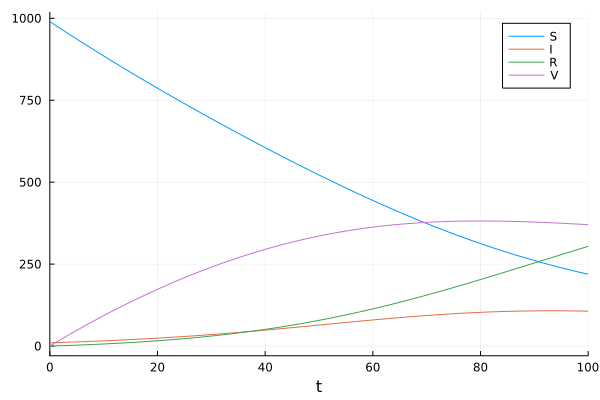

In [21]:
prob_sirv = ODEProblem(vectorfield(sirv),initialValues(sirv),(0.0,100.0),funcFlows(sirv));
sol_sirv = solve(prob_sirv,Tsit5(),abstol=1e-8);
plot(sol_sirv)

In [22]:
#Note: Results are compared with a same Anylogic SIRV model, and proved correct (results are the same)
sol_sirv

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 16-element Vector{Float64}:
   0.0
   1.4266794267279045e-6
   1.569347369400695e-5
   0.0001583614163667974
   0.0015850408430947017
   0.015851835110373743
   0.15851977778316415
   1.5297539157357865
   5.285761015453373
  11.461084677544182
  19.63457933218185
  30.52295722908122
  44.57392896034015
  62.27621041024945
  84.35667814571764
 100.0
u: 16-element Vector{LArray{Float64, 1, Vector{Float64}, (:S, :I, :R, :V)}}:
 4-element LArray{Float64, 1, Vector{Float64}, (:S, :I, :R, :V)}:
 :S => 990.0
 :I => 10.0
 :R => 0.0
 :V => 0.0
 4-element LArray{Float64, 1, Vector{Float64}, (:S, :I, :R, :V)}:
 :S => 989.9999844777279
 :I => 10.000000684806144
 :R => 7.133397372800693e-7
 :V => 1.4124126196751712e-5
 4-element LArray{Float64, 1, Vector{Float64}, (:S, :I, :R, :V)}:
 :S => 989.9998292550165
 :I => 10.000007532869724
 :R => 7.846739740854193e-6
 :V => 0.00015536537410026953
 4-element LArray{Float64, 1, V

# Post-processing of (sum-) dynamical variables

In [23]:
total_population=map(x->funcSVs(sirv)[:N](sol_sirv.u[x],sol_sirv.t[x]),collect(1:length(sol_sirv.t)))

16-element Vector{Float64}:
 1000.0
 1000.0000000000001
 1000.0000000000001
 1000.0000000000001
 1000.0
 1000.0000000000001
 1000.0000000000001
 1000.0000000000001
 1000.0000000000001
 1000.0
 1000.0000000000001
 1000.0000000000001
 1000.0000000000002
 1000.0000000000001
 1000.0000000000002
 1000.0000000000002